# Machine Learning-Driven Portfolio Selection Using K-Means



## Các thư viện được sử dụng
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1.Tải dữ liệu giá cổ phiếu SP500.

In [1]:
!pip install pandas_ta

In [3]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-12-01'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-05 A        41.778675   44.529999   44.689999   44.209999   44.209999   
           AAPL     25.262007   27.277500   27.507500   27.062500   27.500000   
           ABBV     43.165920   60.860001   61.220001   59.570000   59.599998   
           ABT      33.251610   38.430000   38.450001   37.990002   38.110001   
           ACGL     26.609310   27.983334   27.986668   27.553333   27.683332   
...                       ...         ...         ...         ...         ...   
2024-11-29 XYL     126.750000  126.750000  127.830002  126.070000  126.389999   
           YUM     138.270004  138.940002  139.350006  138.289993  139.039993   
           ZBH     111.848251  112.099998  112.419998  111.410004  111.839996   
           ZBRA    407.000000  407.000000  409.029999  405.510010  406.640015   
           ZTS     175.250000  175.250000  177.809998  175.240005  176.929993   

Price                   volume  
date       ticker               
2016-12-05 A         2495000.0  
           AAPL    137298000.0  
           ABBV     10227700.0  
           ABT       9514700.0  
           ACGL      1685400.0  
...                        ...  
2024-11-29 XYL       1084000.0  
           YUM       1003200.0  
           ZBH        504100.0  
           ZBRA       175700.0  
           ZTS       1543400.0  

[990836 rows x 6 columns]

## 2.Tính toán các chỉ báo kỹ thuật cho từng cổ phiếu

* Garman-Klass Volatility
* Relative Strength Index(RSI)
* Bollinger Bands
* Average True Range(ATR)
* Moving Average Convergence Divergence(MACD)
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

Các chỉ số RSI, Bollinger Bands, ATR, and MACD được tính bằng thư viện pandas_ta

In [4]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))



df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std()) #converts the ATR values into z-scores

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std()) #converts the MACD values into z-scores

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-05 A        41.778675   44.529999   44.689999   44.209999   44.209999   
           AAPL     25.262007   27.277500   27.507500   27.062500   27.500000   
           ABBV     43.165920   60.860001   61.220001   59.570000   59.599998   
           ABT      33.251610   38.430000   38.450001   37.990002   38.110001   
           ACGL     26.609310   27.983334   27.986668   27.553333   27.683332   
...                       ...         ...         ...         ...         ...   
2024-11-29 XYL     126.750000  126.750000  127.830002  126.070000  126.389999   
           YUM     138.270004  138.940002  139.350006  138.289993  139.039993   
           ZBH     111.848251  112.099998  112.419998  111.410004  111.839996   
           ZBRA    407.000000  407.000000  409.029999  405.510010  406.640015   
           ZTS     175.250000  175.250000  177.809998  175.240005  176.929993   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-12-05 A         2495000.0         -0.001178        NaN       NaN   
           AAPL    137298000.0         -0.002650        NaN       NaN   
           ABBV     10227700.0         -0.039830        NaN       NaN   
           ABT       9514700.0         -0.007112        NaN       NaN   
           ACGL      1685400.0         -0.000483        NaN       NaN   
...                        ...               ...        ...       ...   
2024-11-29 XYL       1084000.0          0.000093  49.648306  4.788473   
           YUM       1003200.0          0.000017  58.867525  4.879094   
           ZBH        504100.0          0.000041  57.786848  4.679558   
           ZBRA       175700.0          0.000037  65.341500  5.931967   
           ZTS       1543400.0          0.000071  43.293954  5.151669   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-12-05 A            NaN       NaN       NaN       NaN     104.237794  
           AAPL         NaN       NaN       NaN       NaN    3468.423004  
           ABBV         NaN       NaN       NaN       NaN     441.488083  
           ABT          NaN       NaN       NaN       NaN     316.379092  
           ACGL         NaN       NaN       NaN       NaN      44.847331  
...                     ...       ...       ...       ...            ...  
2024-11-29 XYL     4.824384  4.860296  0.808252 -0.602471     137.397000  
           YUM     4.910578  4.942061  0.537278  0.469577     138.712468  
           ZBH     4.707198  4.734837 -0.691755  0.519920      56.382704  
           ZBRA    5.978034  6.024101 -0.141825  0.771518      71.509900  
           ZTS     5.175648  5.199628  0.538936 -0.961171     270.480850  

[990836 rows x 14 columns]

## 3.Tổng hợp dữ liệu theo tháng và lọc ra 150 cổ phiếu có tính thanh khoản cao nhất cho từng tháng.

* Để giảm thời gian huấn luyện và thử nghiệm các đặc điểm và chiến lược, tôi chuyển dữ liệu từ tần suất ngày làm việc sang tần suất cuối tháng.
* Đồng thời loại bỏ các giá trị NaN do việc tính toán các chỉ số.

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-01-31 A          102.160657   46.077377         -0.000397  61.612125   
           AAPL      3120.691359   28.095901         -0.002159  74.588886   
           ABBV       344.889490   43.780567         -0.038072  48.898320   
           ABT        371.924561   36.375004         -0.004523  73.931244   
           ACGL        29.688113   28.003962         -0.001044  60.279026   
...                          ...         ...               ...        ...   
2024-11-30 XYL        213.934131  126.750000          0.000093  49.648306   
           YUM        270.287609  138.270004          0.000017  58.867525   
           ZBH        170.496881  111.848251          0.000041  57.786848   
           ZBRA       144.610414  407.000000          0.000037  65.341500   
           ZTS        519.737877  175.250000          0.000071  43.293954   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-01-31 A       3.801789  3.831351  3.860914 -1.390144  0.145554  
           AAPL    3.327728  3.356231  3.384733 -1.455403 -0.136334  
           ABBV    3.779778  3.810983  3.842188 -1.451583 -0.325105  
           ABT     3.557928  3.591215  3.624503 -1.417245  0.249435  
           ACGL    3.331300  3.355690  3.380080 -1.172897 -0.073724  
...                     ...       ...       ...       ...       ...  
2024-11-30 XYL     4.788473  4.824384  4.860296  0.808252 -0.602471  
           YUM     4.879094  4.910578  4.942061  0.537278  0.469577  
           ZBH     4.679558  4.707198  4.734837 -0.691755  0.519920  
           ZBRA    5.931967  5.978034  6.024101 -0.141825  0.771518  
           ZTS     5.151669  5.175648  5.199628  0.538936 -0.961171  

[46823 rows x 9 columns]

* Tính trung bình động 5 năm của khối lượng giao dịch tính theo giá trị (dollar volume) cho từng cổ phiếu trước khi lọc dữ liệu.
* Lọc dữ liệu để chỉ bao gồm các dòng mà thứ hạng khối lượng giao dịch (dollar_vol_rank) nhỏ hơn 150 (tức là 150 mã cổ phiếu có khối lượng giao dịch cao nhất theo giá trị tại mỗi thời điểm).

In [6]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-12-31 AAPL     39.811535         -0.001775  47.784587  3.698682   
           ABBV     71.096039         -0.039988  55.000989  4.253741   
           ABT      50.525513         -0.006559  59.877845  3.884984   
           ACN     137.983612         -0.004850  65.003614  4.891671   
           ADBE    175.240005          0.000056  51.008419  5.137116   
...                       ...               ...        ...       ...   
2024-11-30 WDAY    249.990005          0.000346  47.728436  5.479930   
           WFC      76.169998          0.000153  71.354604  4.176390   
           WMT      92.295509          0.000039  75.347338  4.394482   
           XOM     117.959999          0.000079  47.988966  4.760781   
           ZTS     175.250000          0.000071  43.293954  5.151669   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-12-31 AAPL    3.724109  3.749536 -1.264206 -0.270078  
           ABBV    4.278529  4.303317 -0.927009  0.082138  
           ABT     3.922018  3.959052 -1.379874  0.162606  
           ACN     4.921786  4.951901 -1.167215  0.223810  
           ADBE    5.167383  5.197650 -1.361543 -0.179861  
...                     ...       ...       ...       ...  
2024-11-30 WDAY    5.560924  5.641919  1.183208  0.654605  
           WFC     4.293863  4.411336  1.713966  3.639124  
           WMT     4.466363  4.538244  2.636584  4.003659  
           XOM     4.789757  4.818733  0.321354 -0.067253  
           ZTS     5.175648  5.199628  0.538936 -0.961171  

[12516 rows x 8 columns]

## 4.Tính toán lợi nhuận hàng tháng cho các khung thời gian khác nhau để sử dụng.

* Để nắm bắt động lực chuỗi thời gian, ví dụ như các mô hình động lượng (momentum patterns), chúng tôi tính toán lợi nhuận lịch sử bằng phương pháp .pct_change(lag), tức là lợi nhuận trong các khoảng thời gian hàng tháng khác nhau được xác định bởi các độ trễ (lags).

In [7]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-12-31 AAPL     37.665619         -0.000835  37.072867  3.585046   
           ABBV     70.416023         -0.026539  57.957296  4.152361   
           ABT      65.209145         -0.003189  55.190133  4.111693   
           ACN     129.389069         -0.002485  36.633903  4.807611   
           ADBE    226.240005          0.000161  46.330419  5.329066   
...                       ...               ...        ...       ...   
2024-11-30 VZ       44.340000          0.000056  62.876613  3.697990   
           WDAY    249.990005          0.000346  47.728436  5.479930   
           WFC      76.169998          0.000153  71.354604  4.176390   
           WMT      92.295509          0.000039  75.347338  4.394482   
           XOM     117.959999          0.000079  47.988966  4.760781   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-12-31 AAPL    3.697134  3.809221 -0.678103 -1.246792  -0.116698   
           ABBV    4.223280  4.294199  0.737661 -0.097050  -0.022064   
           ABT     4.169437  4.227180  0.304853 -0.323911  -0.023228   
           ACN     4.940240  5.072869 -0.156006 -1.466885  -0.142900   
           ADBE    5.452557  5.576047 -0.047485 -0.755799  -0.098250   
...                     ...       ...       ...       ...        ...   
2024-11-30 VZ      3.760144  3.822299 -0.462392  1.116464   0.052457   
           WDAY    5.560924  5.641919  1.183208  0.654605   0.069019   
           WFC     4.293863  4.411336  1.713966  3.639124   0.180051   
           WMT     4.466363  4.538244  2.636584  4.003659   0.128580   
           XOM     4.789757  4.818733  0.321354 -0.067253   0.018405   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-12-31 AAPL    -0.132912  -0.101245  -0.025181  -0.005637   -0.004607  
           ABBV     0.088210  -0.004972   0.002641   0.000530   -0.000801  
           ABT      0.024291  -0.003340   0.030303   0.022655    0.021488  
           ACN     -0.054156  -0.057936  -0.022971  -0.007415   -0.005345  
           ADBE    -0.040535  -0.057180  -0.012388   0.005118    0.021515  
...                      ...        ...        ...        ...         ...  
2024-11-30 VZ       0.001359   0.025301   0.017889   0.016840    0.017668  
           WDAY     0.011351  -0.017006   0.028298  -0.018101   -0.006617  
           WFC      0.164538   0.094247   0.043123   0.037814    0.047908  
           WMT      0.070285   0.061937   0.057997   0.051996    0.045730  
           XOM      0.007265   0.002788   0.003699   0.016271    0.014410  

[10371 rows x 14 columns]

## 5.Tải dữ liệu Fama-French và tính toán hệ số beta của các nhân tố dựa trên cửa sổ lăn (rolling window).

* Chúng ta sẽ sử dụng dữ liệu Fama-French để ước tính mức độ nhạy cảm của tài sản đối với các nhân tố rủi ro chung thông qua hồi quy tuyến tính.

* The five Fama-French factor, bao gồm rủi ro thị trường, quy mô, giá trị, khả năng sinh lời hoạt động và đầu tư, đã được chứng minh thực nghiệm là có khả năng giải thích lợi nhuận tài sản và thường được sử dụng để đánh giá hồ sơ rủi ro/lợi nhuận của danh mục đầu tư. Vì vậy, việc đưa các mức độ nhạy cảm với nhân tố trong quá khứ làm đặc trưng tài chính vào mô hình là điều hợp lý.

* Chúng ta có thể truy cập dữ liệu lợi nhuận nhân tố lịch sử bằng cách sử dụng thư viện pandas-datareader và ước tính mức độ nhạy cảm trong lịch sử bằng hồi quy tuyến tính lăn (rolling linear regression) với RollingOLS.

In [8]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAPL   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.116698
           ABBV   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.023228
           ACN    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.142900
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
...                   ...     ...     ...     ...     ...        ...
2024-11-30 VZ      0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.052457
           WDAY    0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.069019
           WFC     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.180051
           WMT     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.128580
           XOM     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.018405

[10371 rows x 6 columns]

* Loại bỏ những cổ phiếu có số lượng dữ liệu ít hơn 10 tháng

In [9]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAPL   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.116698
           ABBV   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.023228
           ACN    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.142900
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
...                   ...     ...     ...     ...     ...        ...
2024-11-30 VZ      0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.052457
           WDAY    0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.069019
           WFC     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.180051
           WMT     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.128580
           XOM     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.018405

[10343 rows x 6 columns]

* Tính Rolling Factor Betas.

In [10]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-12-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-11-30 VZ      0.885481 -0.606879  0.299135  0.505727  0.276441
           WDAY    0.760453 -1.023488  0.151870 -2.489189 -0.729128
           WFC     0.723452 -0.312081  1.429827 -2.012390 -1.095387
           WMT     0.844558  0.175825 -0.332756  1.279650  0.295547
           XOM     0.614447  0.031141  0.205420  1.179330  0.728192

[10343 rows x 5 columns]

* Kết hợp dữ liệu rolling factors vào dataframe chứa các đặc trưng

In [11]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10159 entries, (Timestamp('2018-12-31 00:00:00'), 'AAPL') to (Timestamp('2024-11-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10159 non-null  float64
 1   rsi               10159 non-null  float64
 2   bb_low            10159 non-null  float64
 3   bb_mid            10159 non-null  float64
 4   bb_high           10159 non-null  float64
 5   atr               10159 non-null  float64
 6   macd              10159 non-null  float64
 7   return_1m         10159 non-null  float64
 8   return_2m         10159 non-null  float64
 9   return_3m         10159 non-null  float64
 10  return_6m         10159 non-null  float64
 11  return_9m         10159 non-null  float64
 12  return_12m        10159 non-null  float64
 13  Mkt-RF            10159 non-null  float64
 14  SMB               10159 non-null  float64
 15  HML       

Lúc này, chúng ta đã có đủ bộ dữ liệu cho mô hình học máy.

Cần quyết định mô hình Machine Learning (ML) và phương pháp tiếp cận sẽ sử dụng cho việc dự đoán, v.v.

Bây giờ cùng sử dụng thuật toán phân cụm K-means


## 6.Với mỗi tháng, áp dụng thuật toán K-Means Clustering để phân nhóm các tài sản tương tự dựa trên các đặc trưng của chúng.





Tạo các centroids cho thuật toán K-mean

In [12]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [13]:
from sklearn.cluster import KMeans

#data = data.drop('adj close', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-12-31 AAPL           -0.000835  37.072867  3.585046  3.697134  3.809221   
           ABBV           -0.026539  57.957296  4.152361  4.223280  4.294199   
           ABT            -0.003189  55.190133  4.111693  4.169437  4.227180   
           ACN            -0.002485  36.633903  4.807611  4.940240  5.072869   
           ADBE            0.000161  46.330419  5.329066  5.452557  5.576047   
...                             ...        ...       ...       ...       ...   
2024-11-30 VZ              0.000056  62.876613  3.697990  3.760144  3.822299   
           WDAY            0.000346  47.728436  5.479930  5.560924  5.641919   
           WFC             0.000153  71.354604  4.176390  4.293863  4.411336   
           WMT             0.000039  75.347338  4.394482  4.466363  4.538244   
           XOM             0.000079  47.988966  4.760781  4.789757  4.818733   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-12-31 AAPL   -0.678103 -1.246792  -0.116698  -0.132912  -0.101245   
           ABBV    0.737661 -0.097050  -0.022064   0.088210  -0.004972   
           ABT     0.304853 -0.323911  -0.023228   0.024291  -0.003340   
           ACN    -0.156006 -1.466885  -0.142900  -0.054156  -0.057936   
           ADBE   -0.047485 -0.755799  -0.098250  -0.040535  -0.057180   
...                     ...       ...        ...        ...        ...   
2024-11-30 VZ     -0.462392  1.116464   0.052457   0.001359   0.025301   
           WDAY    1.183208  0.654605   0.069019   0.011351  -0.017006   
           WFC     1.713966  3.639124   0.180051   0.164538   0.094247   
           WMT     2.636584  4.003659   0.128580   0.070285   0.061937   
           XOM     0.321354 -0.067253   0.018405   0.007265   0.002788   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-12-31 AAPL    -0.025181  -0.005637   -0.004607  1.289316 -0.227871   
           ABBV     0.002641   0.000530   -0.000801  0.533086  0.313191   
           ABT      0.030303   0.022655    0.021488  0.766291 -0.049226   
           ACN     -0.022971  -0.007415   -0.005345  1.200544 -0.203145   
           ADBE    -0.012388   0.005118    0.021515  1.313989 -0.563005   
...                      ...        ...         ...       ...       ...   
2024-11-30 VZ       0.017889   0.016840    0.017668  0.734825 -0.727547   
           WDAY     0.028298  -0.018101   -0.006617  1.140811 -0.823618   
           WFC      0.043123   0.037814    0.047908  0.939100 -0.274310   
           WMT      0.057997   0.051996    0.045730  0.650477 -0.021042   
           XOM      0.003699   0.016271    0.014410  0.366613 -0.109510   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-12-31 AAPL   -0.628085  0.337555  0.477198        3  
           ABBV   -0.145888  0.402110  0.544406        2  
           ABT    -0.438576  0.157058  1.002005        2  
           ACN    -0.225535  0.335008  0.007835        3  
           ADBE   -0.256390  0.315516 -0.425510        1  
...                     ...       ...       ...      ...  
2024-11-30 VZ      0.404303  0.236135  0.079403        2  
           WDAY   -0.098319 -1.512400 -0.115214        1  
           WFC     1.299031 -1.245050 -0.663352        3  
           WMT    -0.191214  1.049416  0.087748        3  
           XOM     0.369962  0.572320  0.339756        1  

[10159 rows x 19 columns]

In [14]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return


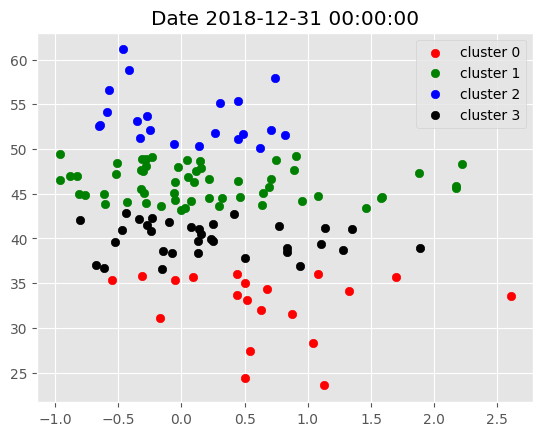

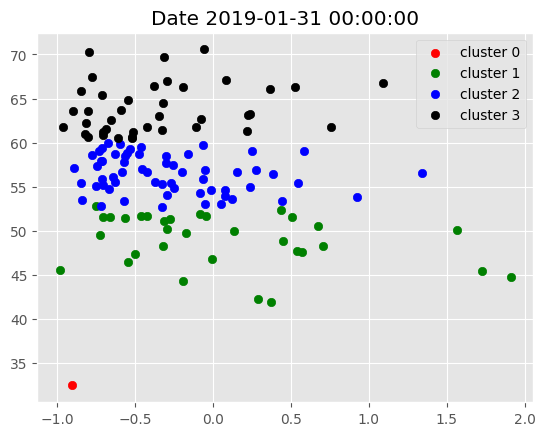

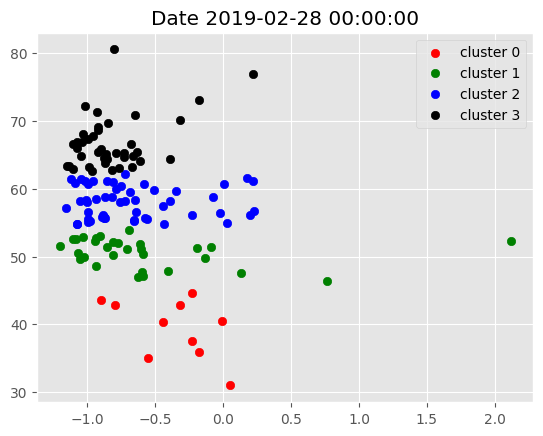

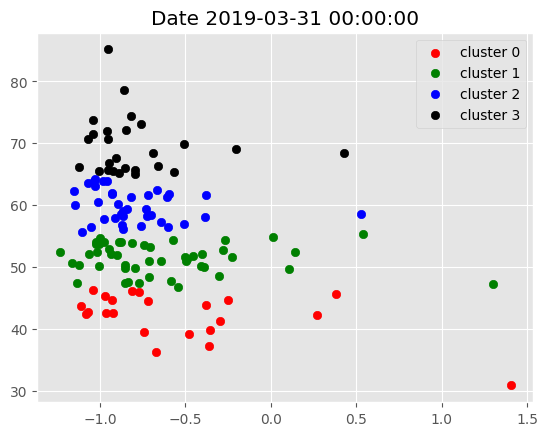

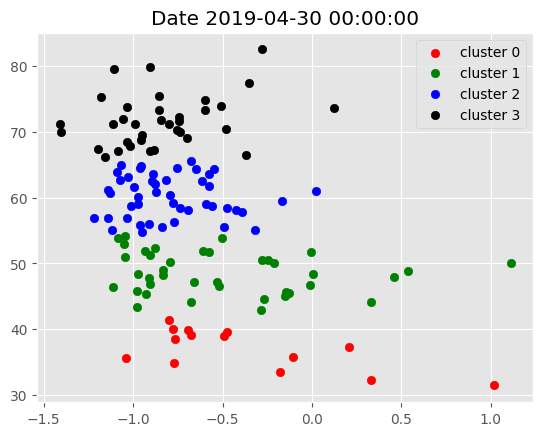

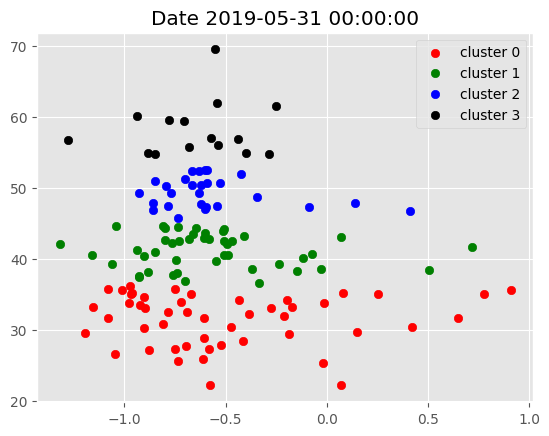

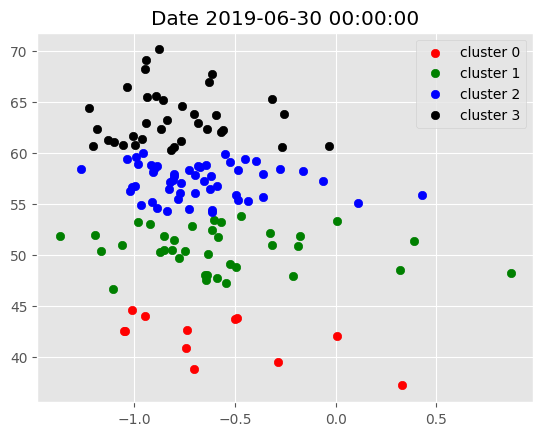

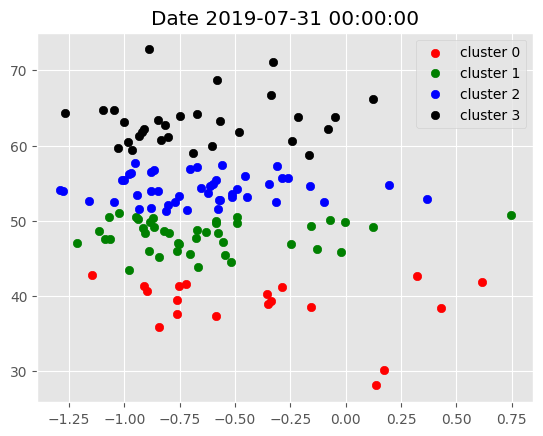

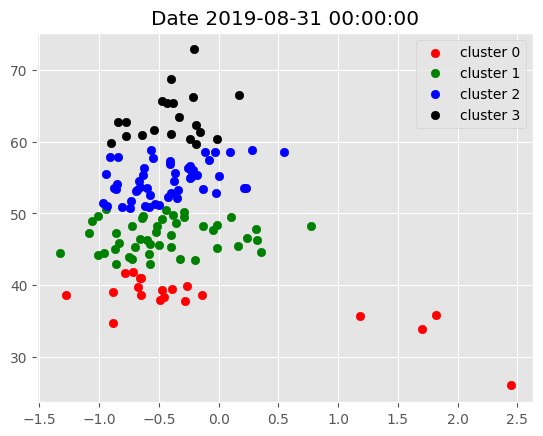

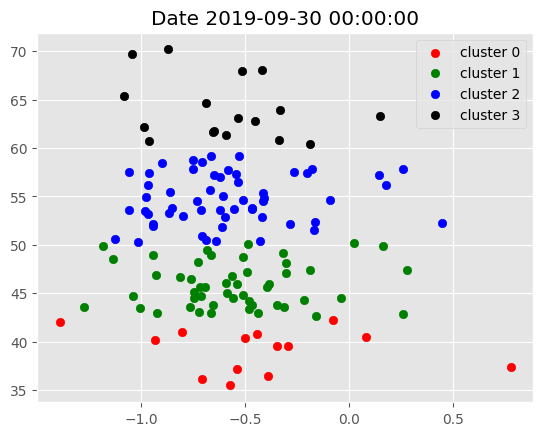

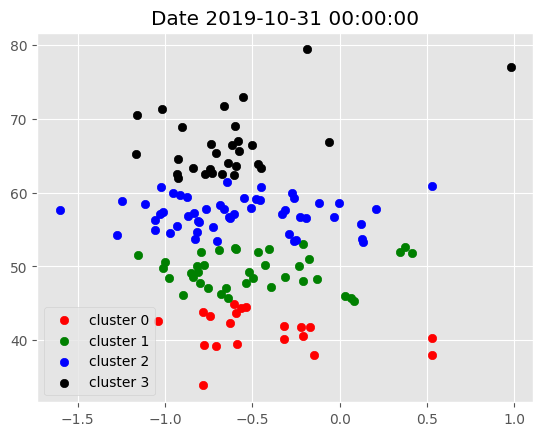

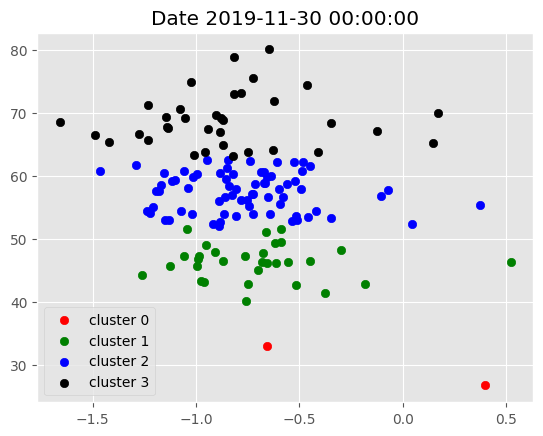

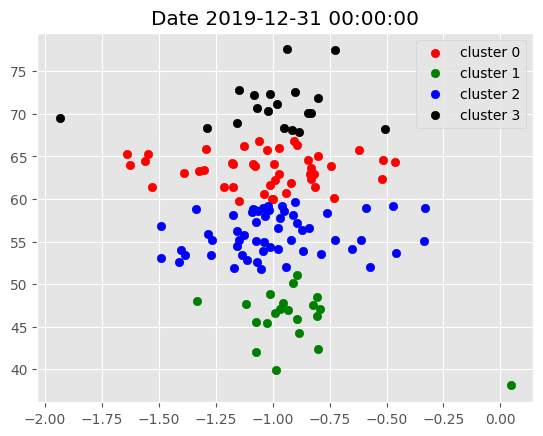

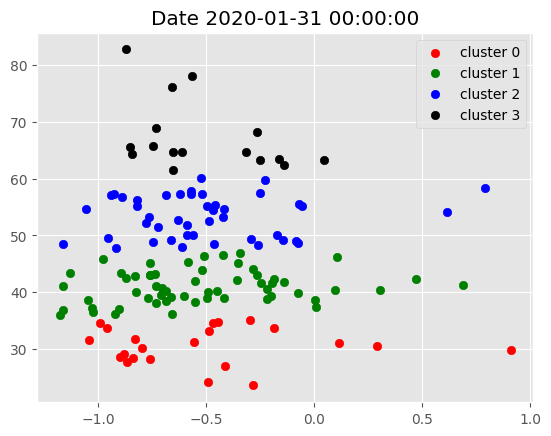

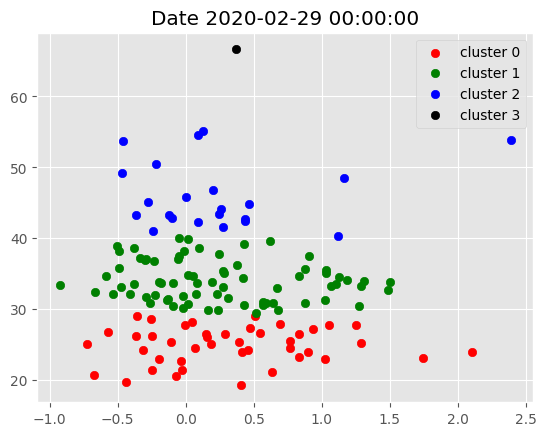

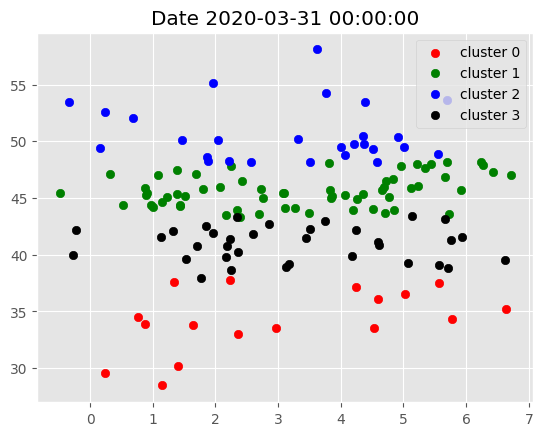

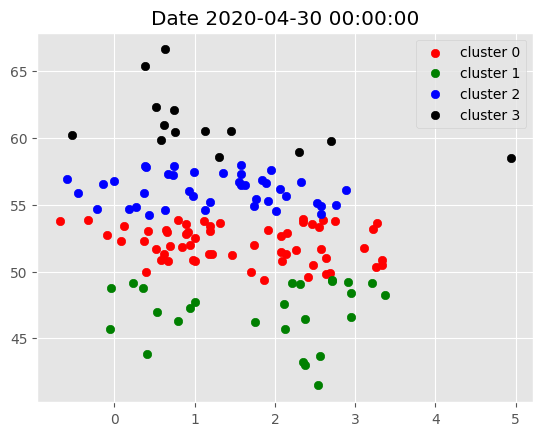

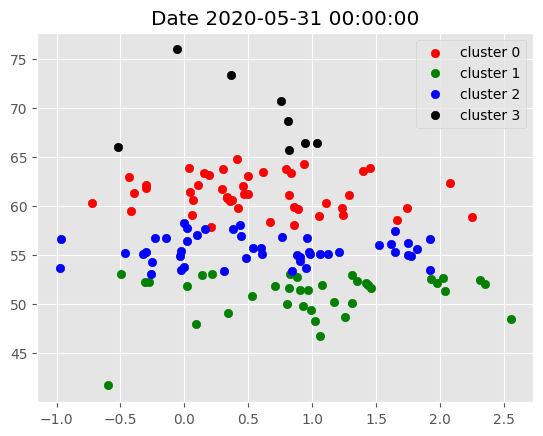

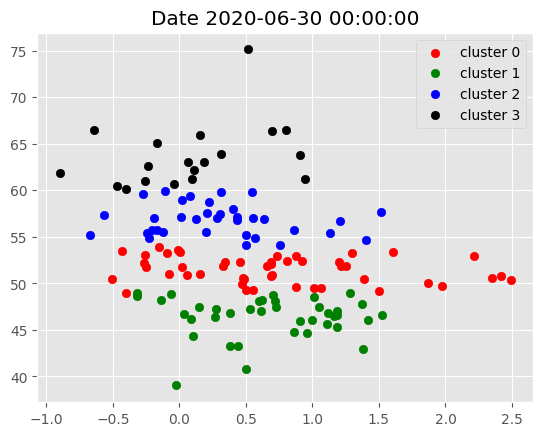

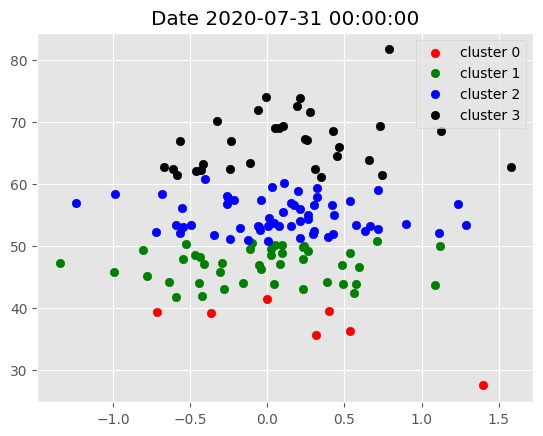

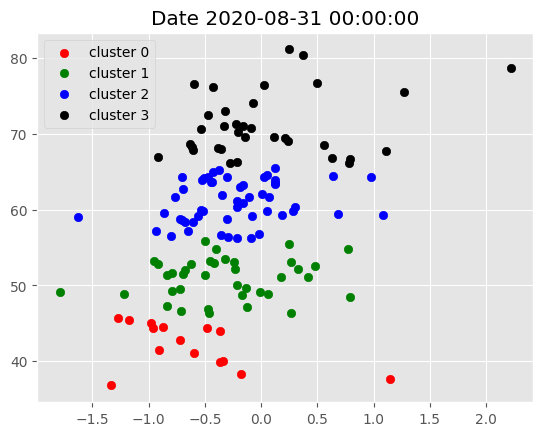

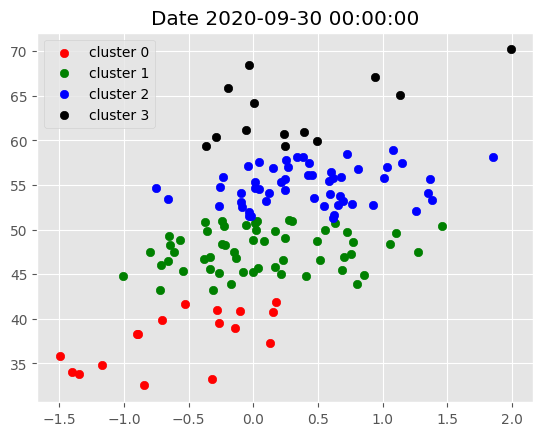

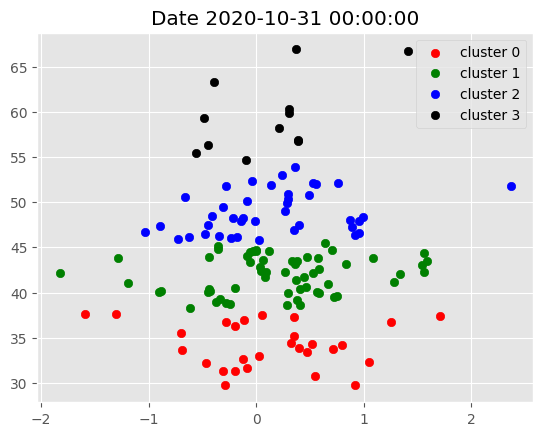

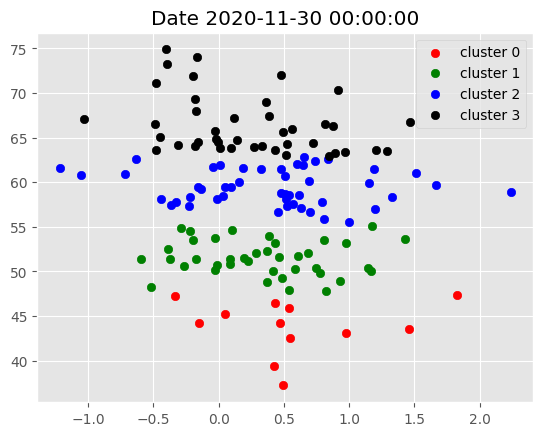

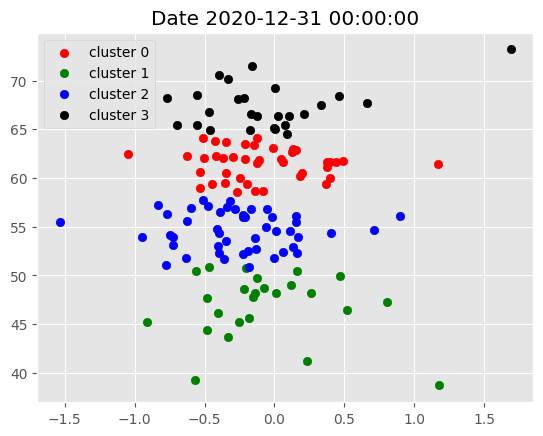

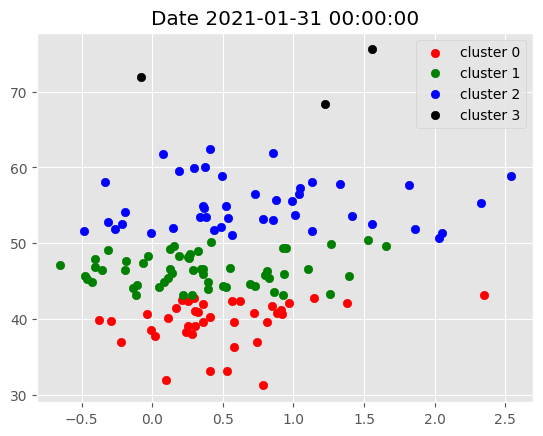

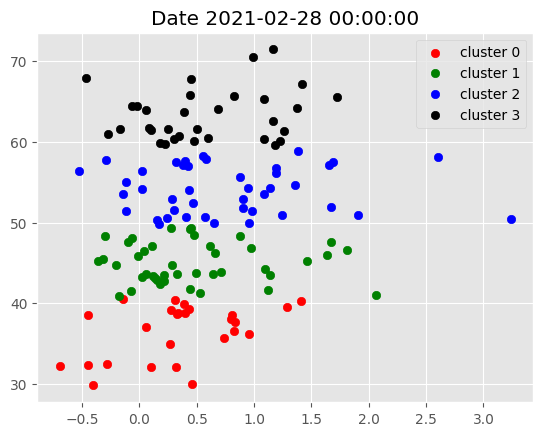

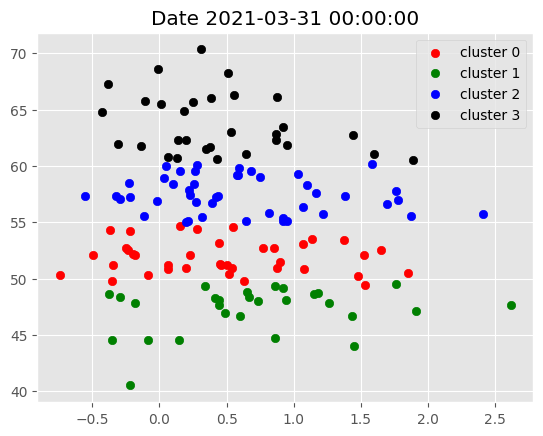

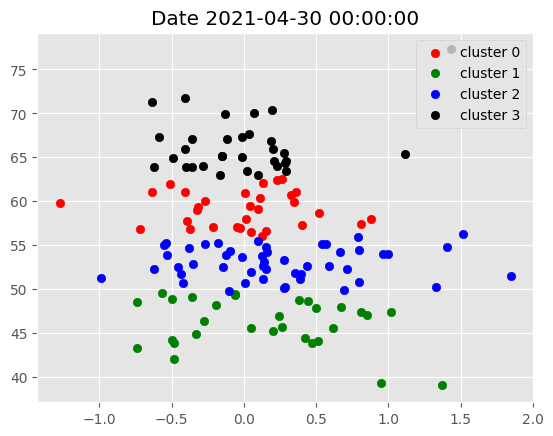

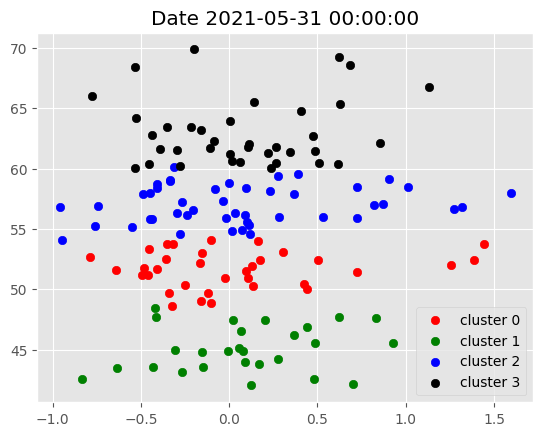

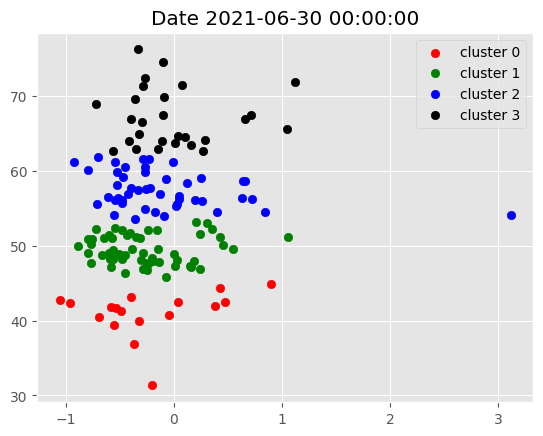

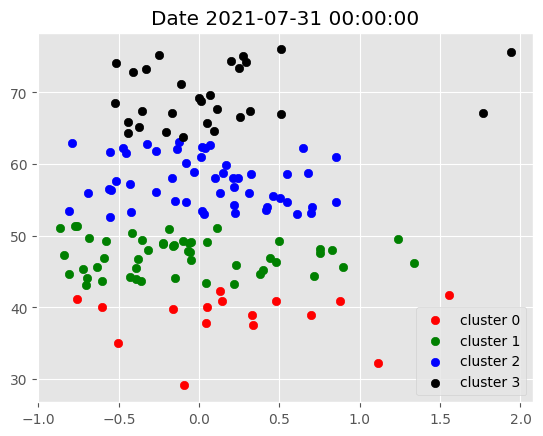

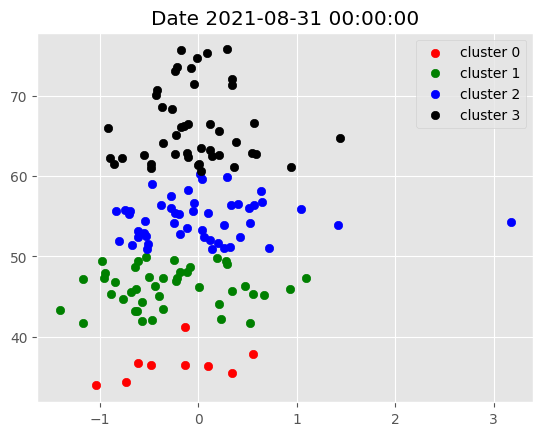

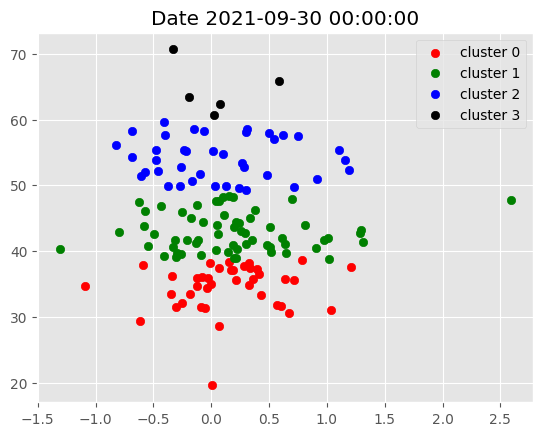

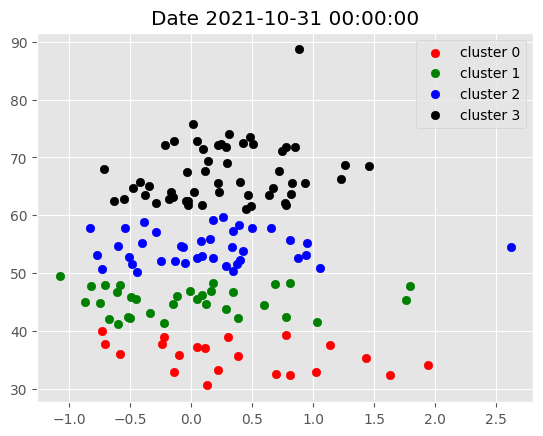

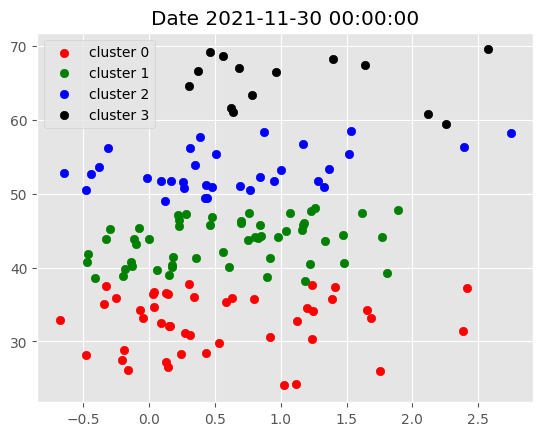

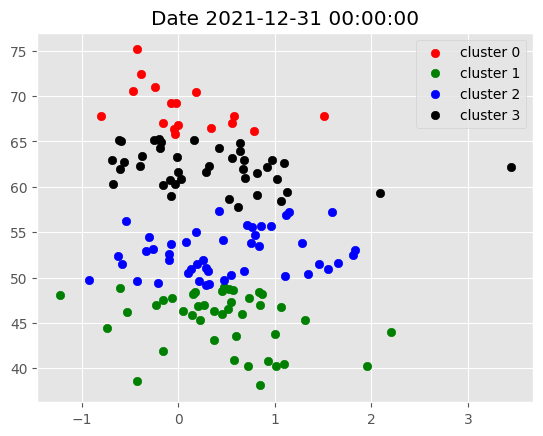

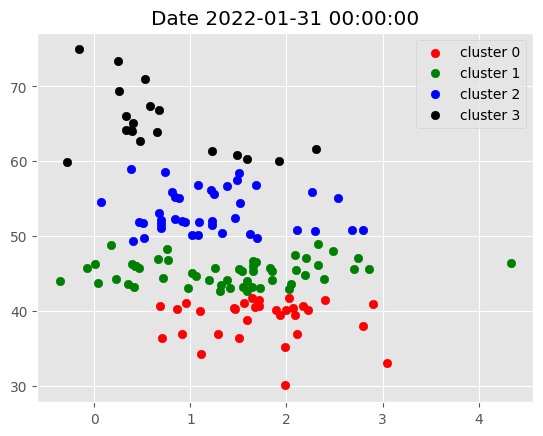

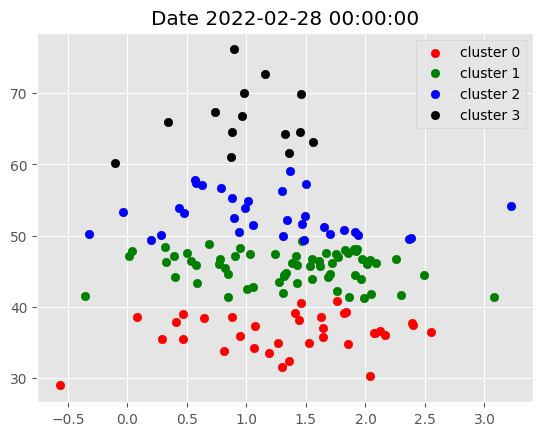

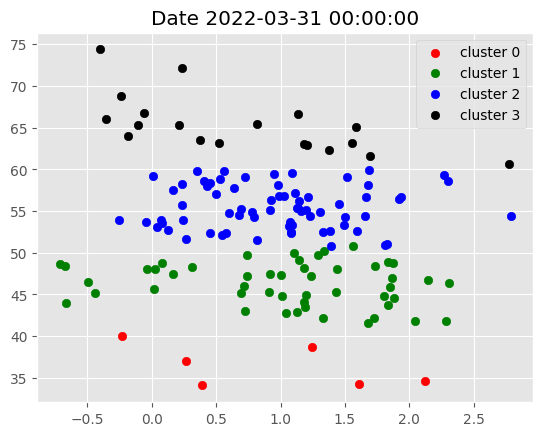

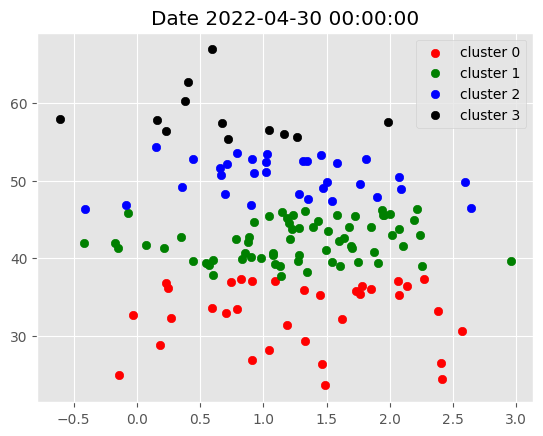

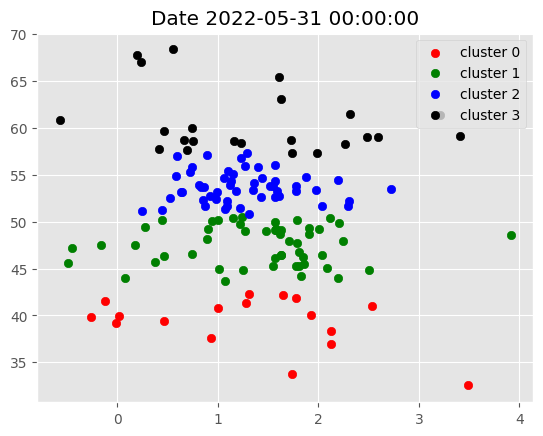

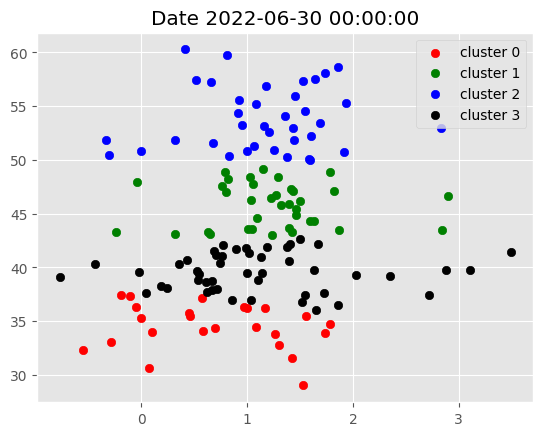

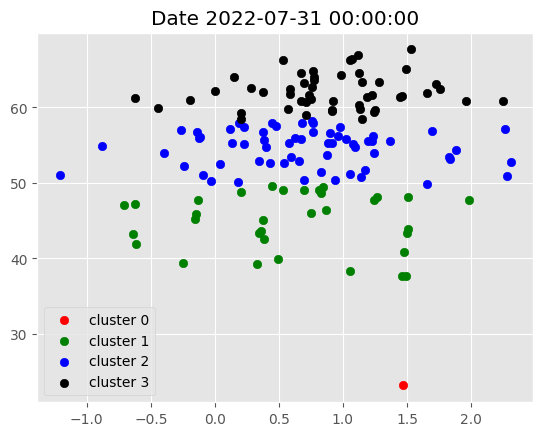

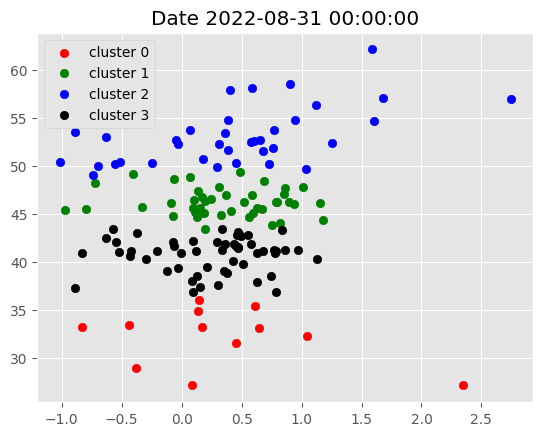

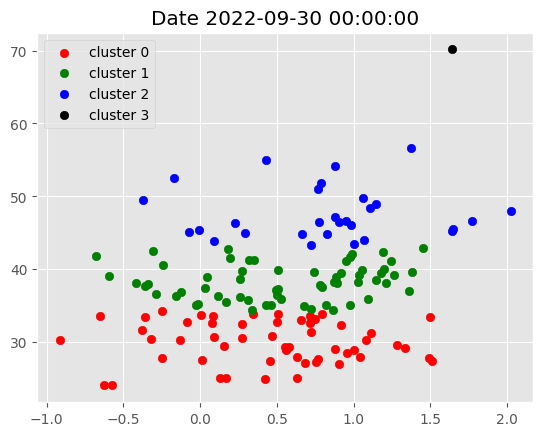

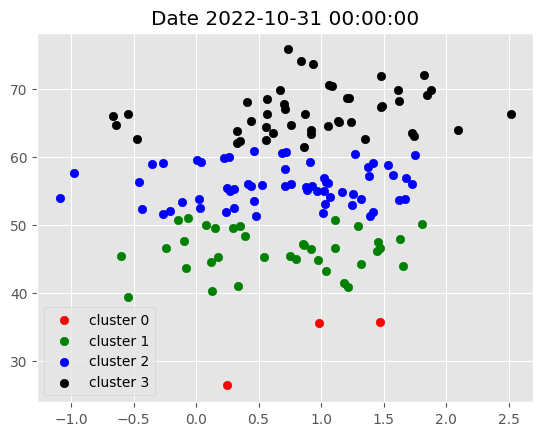

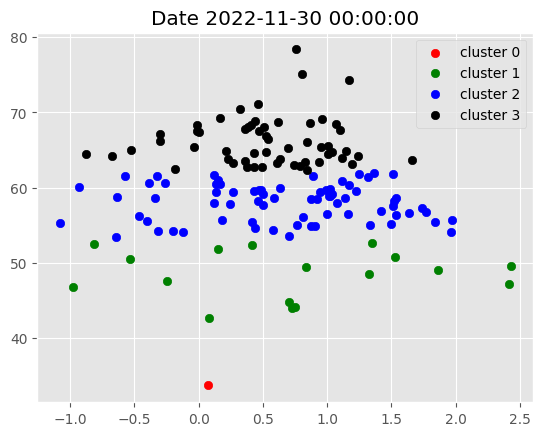

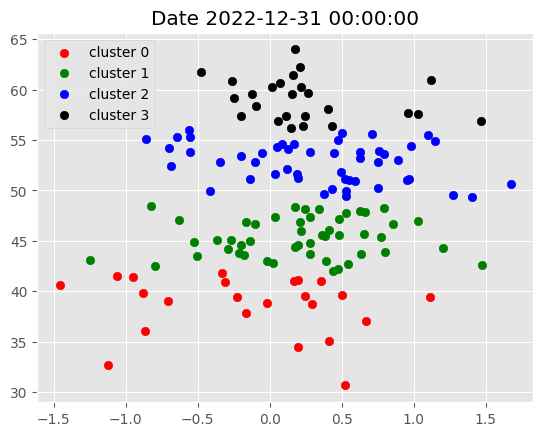

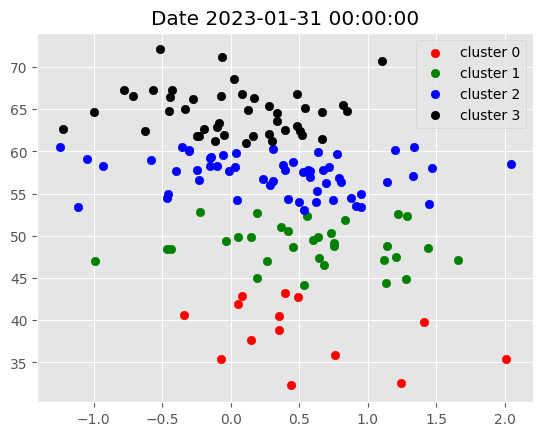

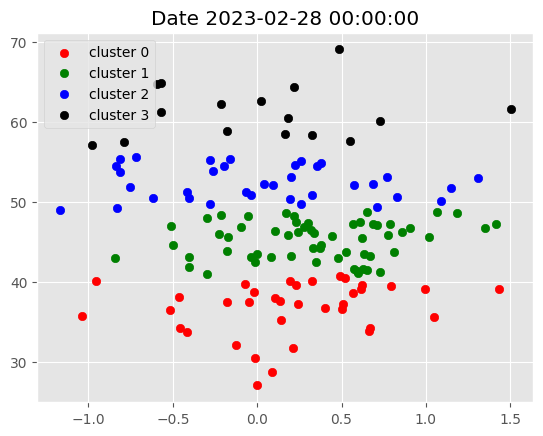

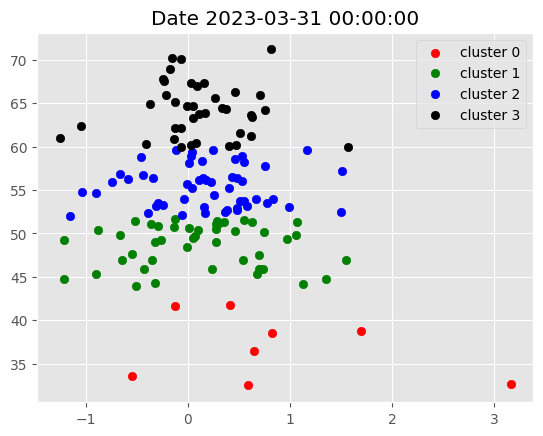

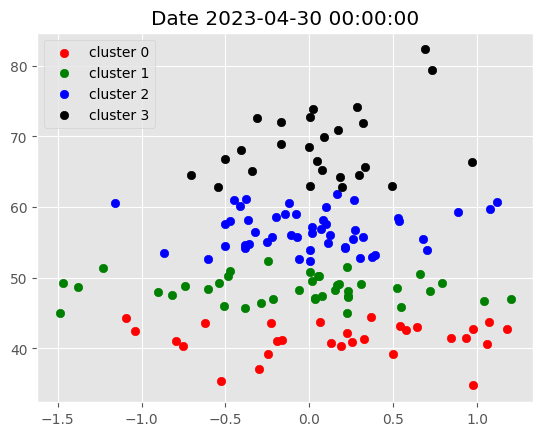

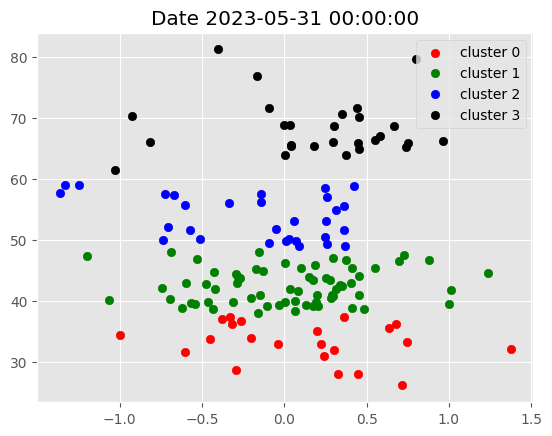

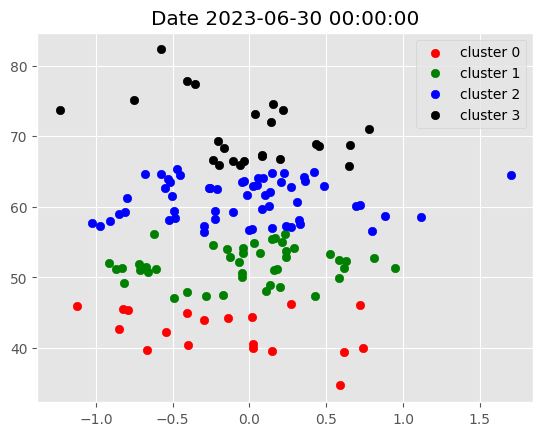

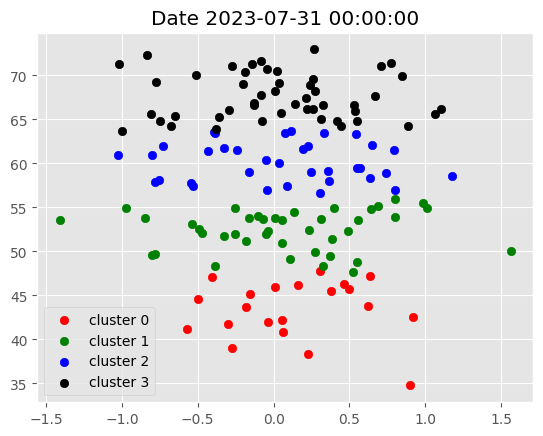

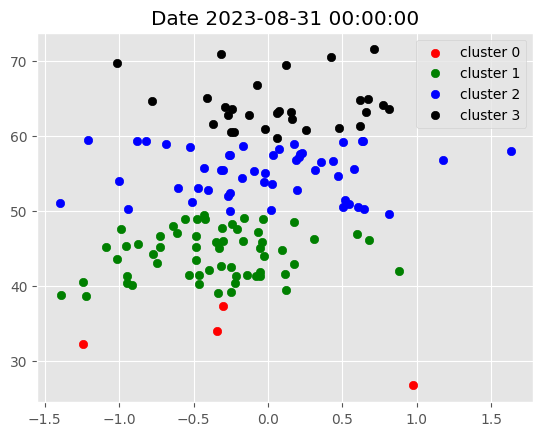

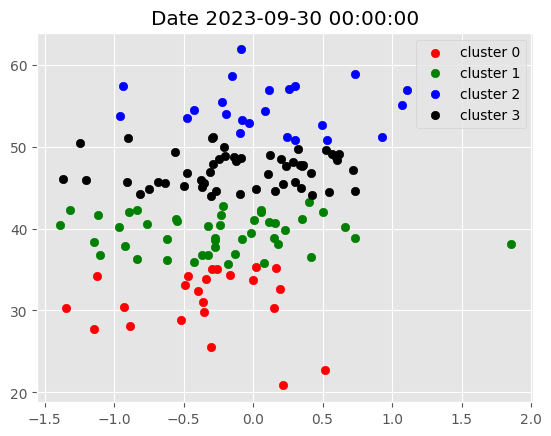

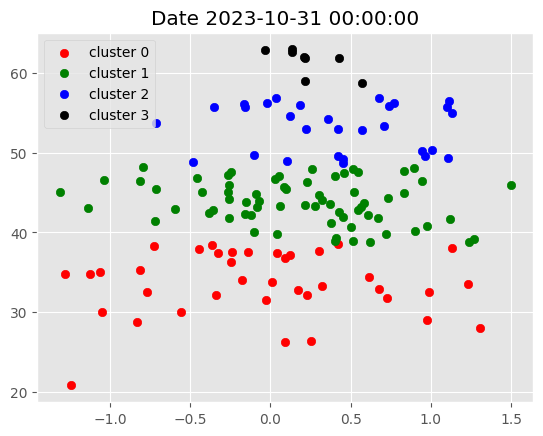

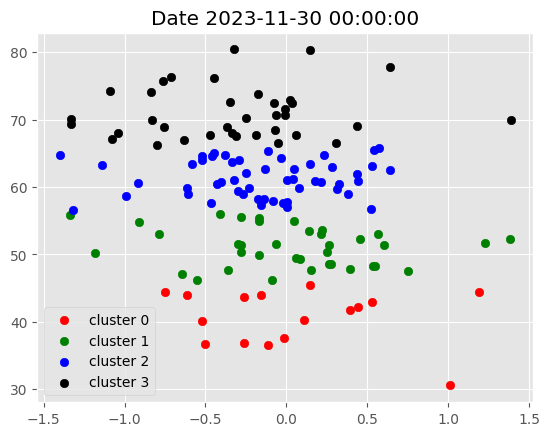

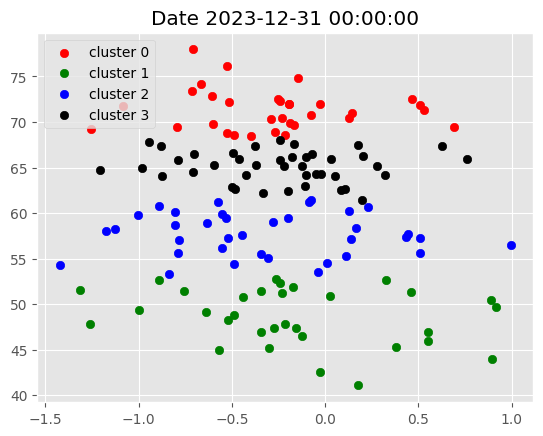

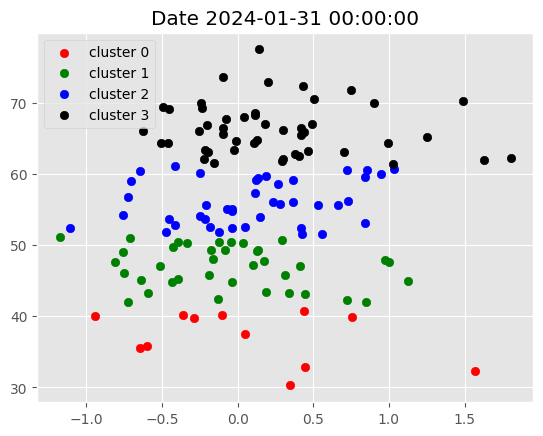

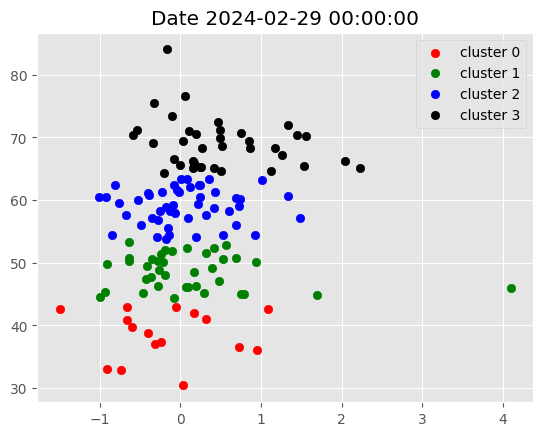

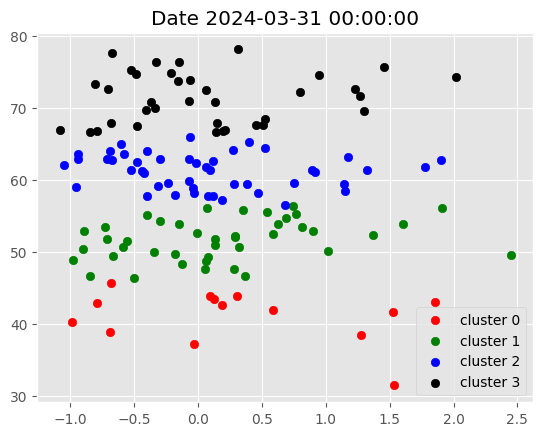

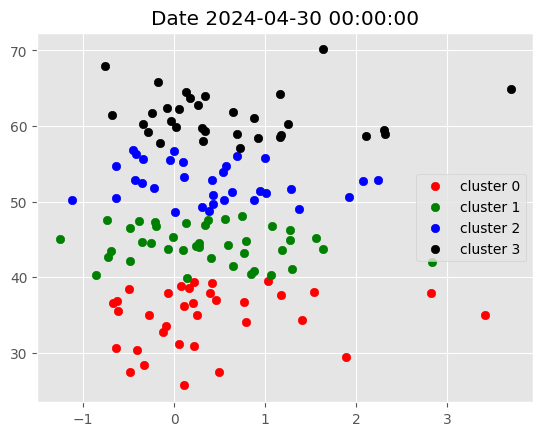

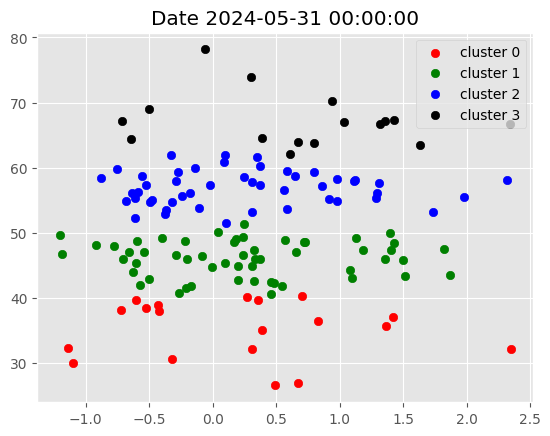

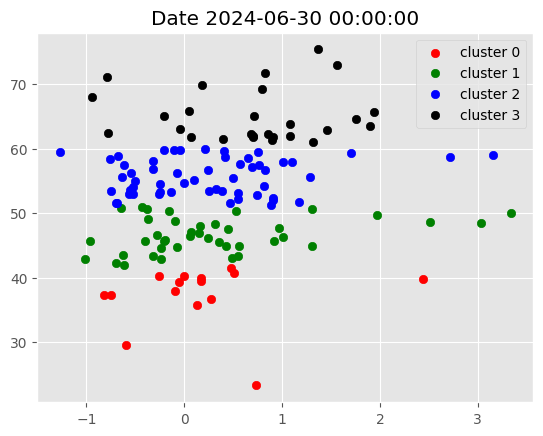

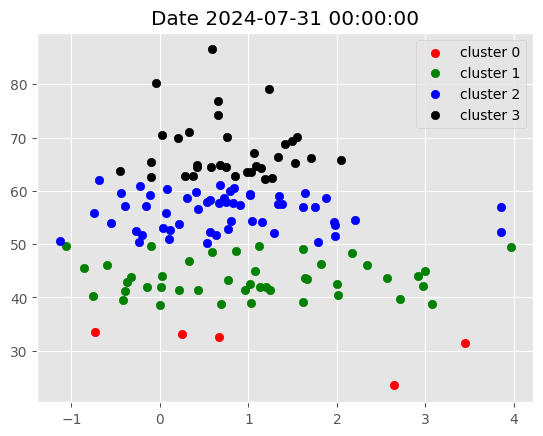

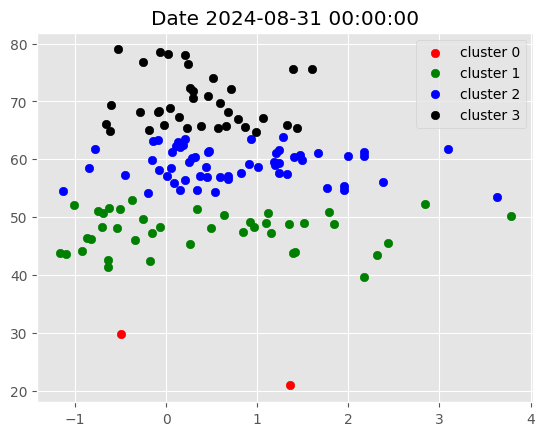

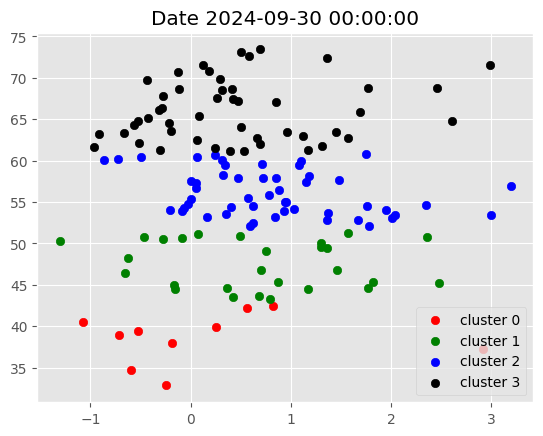

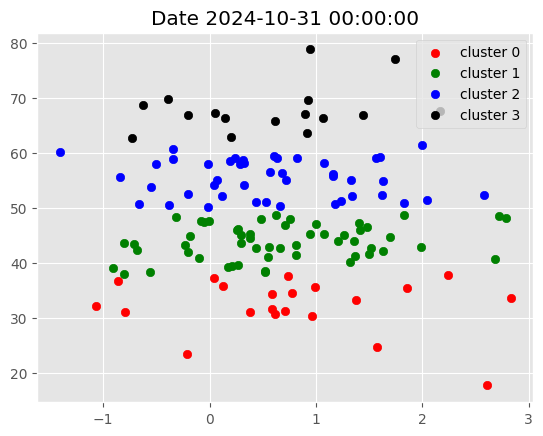

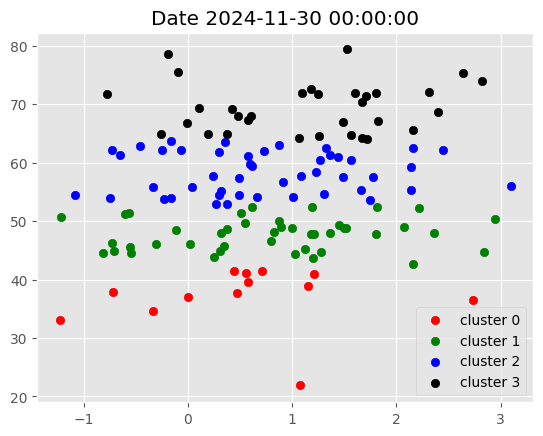

In [15]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

## 7.Đối với mỗi tháng, chọn các tài sản dựa trên cụm (cluster) và hình thành một danh mục đầu tư dựa trên tối ưu hóa tỷ lệ Sharpe tối đa từ Efficient Frontier.

Đầu tieenn, lọc cổ phiếu theo cụm: Dữ liệu đã được chia thành các cụm (clusters) bằng thuật toán K-Means.

Momentum là hiện tượng giá của một tài sản tiếp tục di chuyển theo hướng hiện tại (tăng hoặc giảm) trong một khoảng thời gian. Điều này dựa trên giả thuyết rằng cổ phiếu có động lượng cao (high momentum) trong hiện tại sẽ tiếp tục duy trì hiệu suất tốt trong tương lai gần.

RSI là một chỉ báo động lượng, và giá trị 70 thường được hiểu là mức quá mua (overbought), ám chỉ cổ phiếu đang có xu hướng tăng mạnh. Ở đây, ý tưởng là các cổ phiếu nằm trong cụm có trọng tâm RSI gần 70 (cụm số 3) có khả năng tiếp tục xu hướng tăng trưởng.

Lựa chọn cụm số 3: Dựa trên giả thuyết về momentum, nhóm cổ phiếu thuộc cụm số 3 (cụm có RSI gần 70) được kỳ vọng sẽ có hiệu suất vượt trội trong tháng tiếp theo. Vì vậy, chỉ các cổ phiếu thuộc cụm này được chọn để đưa vào danh mục đầu tư.


In [16]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2019-01-01': ['AAPL',
  'ACN',
  'ADP',
  'AXP',
  'BAC',
  'CHTR',
  'CI',
  'CMCSA',
  'COST',
  'CSX',
  'DAL',
  'EA',
  'EXPE',
  'FCX',
  'GILD',
  'HON',
  'HUM',
  'IBM',
  'JNJ',
  'JPM',
  'MCK',
  'META',
  'MS',
  'MU',
  'OXY',
  'T',
  'TGT',
  'TJX',
  'TMUS',
  'ULTA',
  'UPS',
  'VLO',
  'WFC'],
 '2019-02-01': ['ADI',
  'ADSK',
  'AMAT',
  'AMD',
  'AMT',
  'AVGO',
  'BA',
  'BDX',
  'C',
  'CHTR',
  'CMG',
  'CSCO',
  'DG',
  'DHR',
  'DLTR',
  'EBAY',
  'ELV',
  'GE',
  'GM',
  'IBM',
  'LRCX',
  'LUV',
  'MA',
  'MCK',
  'MDLZ',
  'META',
  'MGM',
  'NKE',
  'NXPI',
  'ORCL',
  'PANW',
  'PG',
  'REGN',
  'SBUX',
  'SHW',
  'TJX',
  'USB',
  'VLO',
  'WYNN'],
 '2019-03-01': ['ABT',
  'ACN',
  'ADBE',
  'ADI',
  'ADP',
  'ADSK',
  'AMT',
  'AXP',
  'AZO',
  'BA',
  'BLK',
  'CHTR',
  'CMG',
  'CRM',
  'CSCO',
  'CSX',
  'DHR',
  'EBAY',
  'HON',
  'IBM',
  'INTC',
  'INTU',
  'LLY',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MRK',
  'NEE',
  'NKE',
  'NOC',
  'ORCL',
  

### Xác định hàm tối ưu hóa danh mục đầu tư.

* Chúng ta sẽ định nghĩa một hàm để tối ưu hóa trọng số danh mục đầu tư bằng cách sử dụng thư viện PyPortfolioOpt và công cụ tối ưu hóa EfficientFrontier nhằm tối đa hóa Sharpe ratio.

Sharpe Ratio là một chỉ số quan trọng trong lĩnh vực tài chính, được sử dụng để đánh giá hiệu suất điều chỉnh theo rủi ro của một danh mục đầu tư hoặc một tài sản tài chính. Nó đo lường mức độ lợi nhuận vượt trội mà một nhà đầu tư nhận được so với rủi ro đã chịu.

Để tối ưu hóa trọng số cho một danh mục đầu tư nhất định, chúng ta cần cung cấp giá cổ phiếu trong 1 năm gần nhất cho hàm này.

Áp dụng ràng buộc về trọng số cho từng cổ phiếu nhằm đảm bảo sự đa dạng hóa (tối thiểu bằng một nửa trọng số phân bổ đều và tối đa là 10% của danh mục đầu tư).

In [17]:
!pip install pyportfolioopt


In [18]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()


* Tải dữ liệu giá hàng ngày mới nhất chỉ dành cho các cổ phiếu đã được chọn lọc.

In [19]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  154 of 154 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2018-01-02   40.524342   72.345779   52.048275  138.659607  177.699997   
2018-01-03   40.517288   73.477905   52.163357  139.299576  181.039993   
2018-01-04   40.705486   73.058868   52.074837  140.949005  183.220001   
2018-01-05   41.168938   74.330658   52.225346  142.111694  185.339996   
2018-01-08   41.016018   73.139732   52.074837  143.247345  185.039993   
...                ...         ...         ...         ...         ...   
2024-11-22  229.869995  176.949997  117.760002  358.660004  512.150024   
2024-11-25  232.869995  177.059998  118.129997  361.290009  518.729980   
2024-11-26  235.059998  181.139999  117.959999  363.179993  525.299988   
2024-11-27  234.929993  183.080002  118.949997  362.160004  513.679993   
2024-11-29  237.330002  182.929993  118.769997  362.369995  515.929993   

Price                                                                   ...  \
Ticker             ADI         ADP        ADSK        ALGN        AMAT  ...   
Date                                                                    ...   
2018-01-02   79.129051  100.113693  107.120003  224.619995   48.919426  ...   
2018-01-03   80.110703  101.201271  109.379997  231.199997   49.786392  ...   
2018-01-04   80.023087  102.167976  112.070000  233.300003   50.072319  ...   
2018-01-05   80.347351  102.107552  110.839996  241.070007   50.358223  ...   
2018-01-08   80.487610  101.796822  111.419998  248.899994   51.575684  ...   
...                ...         ...         ...         ...         ...  ...   
2024-11-22  213.685211  303.576996  321.269989  225.889999  174.880005  ...   
2024-11-25  222.637314  303.099518  319.390015  240.520004  174.550003  ...   
2024-11-26  218.126419  306.382477  317.959991  227.929993  173.199997  ...   
2024-11-27  216.254349  305.337891  290.640015  229.660004  171.320007  ...   
2024-11-29  217.130630  305.347839  291.899994  232.770004  174.710007  ...   

Price        Volume                                                   \
Ticker          VLO     VRTX        VZ       WBA      WDAY       WDC   
Date                                                                   
2018-01-02  3582900  1382000  16045300   6605000   1599600   3894000   
2018-01-03  3057600  1604000  16662400   7147300   2047900   3253300   
2018-01-04  2977000  1345100  12062800  12456000   2774000   5173100   
2018-01-05  2973800  1940000  13348900   9067200   1025400   2727400   
2018-01-08  2493400  1987000  16212700   5312500   1626600   4875300   
...             ...      ...       ...       ...       ...       ...   
2024-11-22  2375200  1270400  17017400  20106600   1997700   5180900   
2024-11-25  4237200  2168200  28365900  29645100   3352900   8819000   
2024-11-26  1728600  1327700  17247000  17438100   4189900  10728100   
2024-11-27  1907000  1006900  12372400  13827900  13910300  10284500   
2024-11-29  1554100   770600   9023100  10057000   2733700   2756300   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2018-01-02  13819300  30451500  2581200  11469300  
2018-01-03  14203700  26710800  3530900  13957700  
2018-01-04  18740500  20491200  2708800  10863000  
2018-01-05  14217900  21852000  2186600  11047600  
2018-01-08  15569400  26531700  1803800  10927100  
...              ...       ...      ...       ...  
2024-11-22  14997400  23990600  1620000  13323400  
2024-11-25  28636600  25078600  3055000  26580300  
2024-11-26  19139100  16657000  1807500  14827300  
2024-11-27  19793900  14358900  1436600  11079100  
2024-11-29   9785000  11041200  1402500   9426500  

[1740 rows x 924 columns]

* Tính toán lợi nhuận hàng ngày cho từng cổ phiếu có khả năng nằm trong danh mục đầu tư.

* Sau đó, lặp qua ngày đầu mỗi tháng, chọn các cổ phiếu cho tháng đó và tính toán trọng số của chúng cho tháng tiếp theo.

* Nếu tối ưu hóa trọng số theo tỷ lệ Sharpe tối đa thất bại trong một tháng cụ thể, áp dụng trọng số phân bổ đều.

* Tính toán lợi nhuận danh mục đầu tư hàng ngày cho từng ngày.

In [20]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
returns_dataframe.columns = returns_dataframe.columns.rename(None)

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T


        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2019-01-02,0.002981
2019-01-03,-0.022567
2019-01-04,0.034783
2019-01-07,0.010803
2019-01-08,0.008270
...,...
2024-11-22,0.007283
2024-11-25,-0.001600
2024-11-26,0.007385


## 8.Trực quan hóa lợi nhuận danh mục đầu tư và so sánh với lợi nhuận của chỉ số S&P 500.

In [21]:
spy = yf.download(tickers='SPY',
                  start='2019-06-03',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna()

spy_ret.columns = spy_ret.columns.droplevel(1)
spy_ret.columns = spy_ret.columns.get_level_values(0)  # Giữ lại giá trị 'Adj Close'
spy_ret = spy_ret.reset_index()
spy_ret.columns.name = None
spy_ret = spy_ret.set_index('Date')
spy_ret = spy_ret.rename({'Adj Close' : 'SPY Buy&Hold'}, axis = 1)
spy_ret
portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df




[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2019-06-04,0.009130,0.021474
2019-06-05,0.011194,0.008625
2019-06-06,0.006115,0.006482
2019-06-07,0.008791,0.009957
2019-06-10,-0.003321,0.004579
...,...,...
2024-11-22,0.007283,0.003095
2024-11-25,-0.001600,0.003386
2024-11-26,0.007385,0.005208
2024-11-27,-0.000019,-0.003035


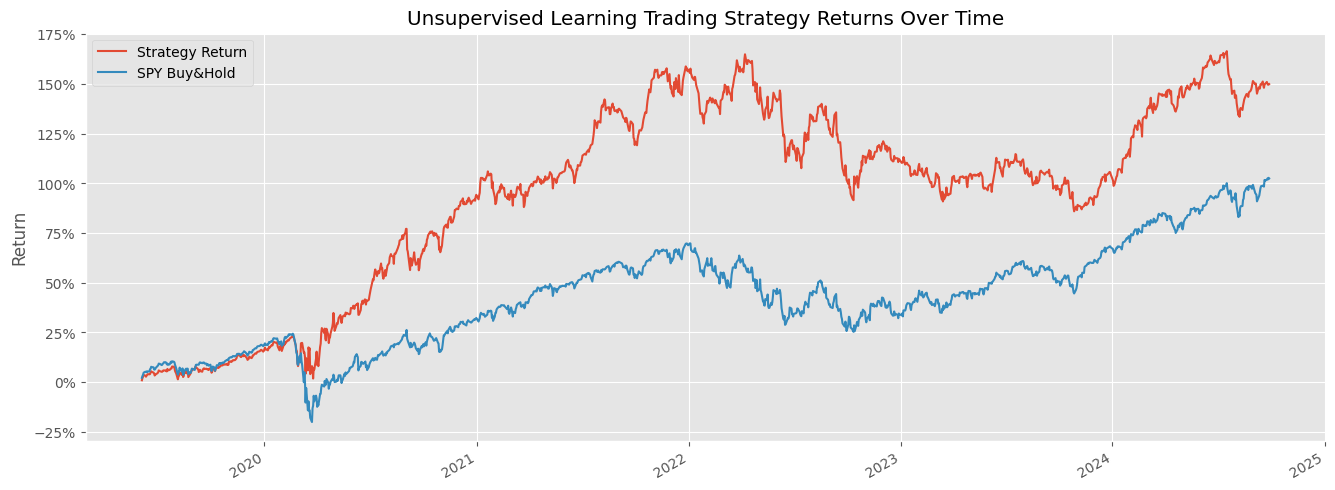

In [22]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


**Nhận xét:**

* Hiệu suất chiến lược:

Chiến lược học máy cho thấy hiệu suất vượt trội so với S&P 500 trong giai đoạn từ 2020 đến cuối 2023, với tổng lợi nhuận cao hơn đáng kể.
Tuy nhiên, sự vượt trội này đi kèm với độ biến động cao hơn, thể hiện qua những biến động lớn trong đường lợi nhuận của chiến lược.

* Giai đoạn suy thoái thị trường:

Trong giai đoạn suy thoái thị trường vào đầu năm 2020 (đại dịch COVID-19), cả hai chiến lược đều có lợi nhuận âm, nhưng chiến lược học máy hồi phục nhanh hơn so với S&P 500.

* Giai đoạn tăng trưởng:

Trong các giai đoạn thị trường tăng trưởng (2021-2022), chiến lược học máy tiếp tục dẫn đầu nhờ khả năng lựa chọn cổ phiếu hiệu quả dựa trên mô hình.

* Hạn chế:

Đường lợi nhuận của chiến lược học máy có xu hướng giảm nhanh hơn S&P 500 trong các đợt điều chỉnh mạnh, cho thấy chiến lược có thể chưa tối ưu hóa tốt về quản lý rủi ro.

**Kết luận:**

* Chiến lược giao dịch dựa trên học máy không giám sát cho thấy tiềm năng vượt trội so với chiến lược mua và giữ S&P 500, đặc biệt trong việc tận dụng các cơ hội lợi nhuận. Tuy nhiên, cần cân nhắc đến độ biến động cao hơn và cải thiện quản lý rủi ro để tăng hiệu quả dài hạn.